![alt text](Fandango_2014.svg "Fandango logo")

# Investigating Fandango Movie Ratings
***
## Introduction

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest ([Fandango](https://www.fandango.com) is an online movie ratings aggregator and movie ticket seller). He published his full analysis in [this article](https://fivethirtyeight.com/features/fandango-movies-ratings/). According to Walt's analysis, there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:

- The actual rating was almost always **rounded up** to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
- In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
- For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.



Fandango displayed a 5-star rating system on their website, where the minimum rating is 0 stars and the maximum is 5 stars.
![Fandango Age of Ultron Ratings](Fandango_Age_of_Ultron.png)



At the time of this writing (December 2021), Fandango no longer publishes their own movie rating, instead, they now only show Rotten Tomatoes' ratings in their website.
![Fandango Dune Ratings](Fandango_Dune.png)



The graphs below shows that Fandango's movie ratings distribution are strongly skewed left and there's no rating under 2 stars in the sample Hickey analyzed. This suggests that movie ratings on Fandango were generally high compared to other competitors.

![Fandango Inflated Ratings](Fandango_Inflated_Ratings.png)
Source: *[Be Suspicious Of Online Movie Ratings, Especially Fandango’s](https://fivethirtyeight.com/features/fandango-movies-ratings/)*

When Hickey asked Fandango about its rounding practice, e.g. 4.1 is rounded to 4.5, Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.
***
## Goal
In this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.
*** 
## Data
We'll work with two samples of movie ratings:the data in one sample was collected previous to Hickey's analysis, while the other sample was collected after. Let's start by reading in the two samples (which are stored as CSV files) and getting familiar with their structure.

- Walt Hickey made the data he analyzed publicly available on [GitHub](https://github.com/fivethirtyeight/data/tree/master/fandango). We'll use the data he collected to analyze the characteristics of Fandango's rating system previous to his analysis.

- One of Dataquest's team members collected movie ratings data for movies released in 2016 and 2017. The data is publicly available on [Github](https://github.com/mircealex/Movie_ratings_2016_17) and we'll use it to analyze the rating system's characteristics after Hickey's analysis.
***
## Analysis
First, we import all the necessary libraries and read all CSV files into a dataframe.

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import arange
%matplotlib inline

fandango_before = pd.read_csv('fandango_score_comparison.csv')
fandango_after  = pd.read_csv('movie_ratings_16_17.csv')

In [2]:
fandango_before.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,...,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,...,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


In [3]:
fandango_after.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


Below we isolate only the columns with normalized ratings to 0-5 scale and clean column names for easy comparison.

In [4]:
movie_critics = ['Fandango', 'Metacritic', 'IMDb', 'Rotten Tomatoes']

before_normalized_columns = [col for col in fandango_before.columns if 'norm' in col]
before = fandango_before[['FILM', 'Fandango_Stars'] + before_normalized_columns].copy()
before.columns = before.columns.str.replace('_norm', '')
before.drop('RT_user', axis = 1, inplace = True) # dropping RT user score
before.rename({'Fandango_Stars': 'Fandango', 'nr_metascore': 'Metacritic', 'IMDB': 'IMDb', 'RT': 'Rotten Tomatoes'}, 
              axis = 1, inplace = True)
before = before[['FILM'] + movie_critics] # rearranging columns
before['Average'] = before.iloc[:, 2:].mean(axis=1).round(1)  # average of other movie reviewers

after_normalized_columns = [col for col in fandango_after.columns if 'nr' in col]
after = fandango_after[['movie', 'fandango'] + after_normalized_columns].copy()
after.columns = after.columns.str.replace('nr_', '').str.title()
after.drop('Audience', axis = 1, inplace = True) # dropping RT user score
after.rename({'Metascore': 'Metacritic', 'Imdb': 'IMDb', 'Tmeter': 'Rotten Tomatoes'}, axis = 1, inplace = True)
after['Average'] = after.iloc[:, 2:].mean(axis = 1).round(1)  # average of other movie reviewers

after.head()

,Movie,Fandango,Metacritic,IMDb,Rotten Tomatoes,Average
0,10 Cloverfield Lane,3.5,4.0,3.5,4.5,4.0
1,13 Hours,4.5,2.5,3.5,2.5,2.8
2,A Cure for Wellness,3.0,2.5,3.5,2.0,2.7
3,A Dog's Purpose,4.5,2.0,2.5,1.5,2.0
4,A Hologram for the King,3.0,3.0,3.0,3.5,3.2


### Is Fandango still inflating ratings in 2016 and 2017?
Let's look at the distribution of the movie ratings after they promised to fix it.

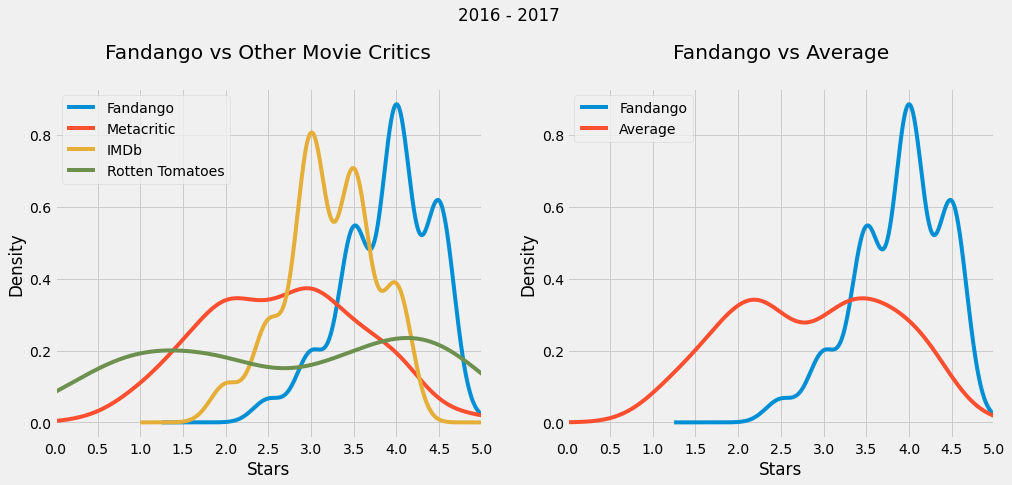

In [5]:
plt.style.use('fivethirtyeight')

# plot 1
plt.subplot(1,2,1)
for movie_rater in movie_critics:
    after[movie_rater].plot.kde(label = movie_rater, legend = True, figsize = (15,6))

plt.title("Fandango vs Other Movie Critics",
          y = 1.07) # the `y` parameter pads the title upward
plt.xlabel('Stars')
plt.xlim(0,5) # because ratings start at 0 and end at 5
plt.xticks(arange(0,5.1,.5))

# plot 2
plt.subplot(1, 2, 2)
after['Fandango'].plot.kde(label = 'Fandango', legend = True)
after['Average'].plot.kde(label = 'Average', legend = True)

plt.title("Fandango vs Average",
          y = 1.07)
plt.xlabel('Stars')
plt.xlim(0,5)
plt.xticks(arange(0,5.1,.5))
plt.suptitle('2016 - 2017', y = 1.07)
plt.show()

It's clear from the graphs above that Fandango is still inflating its movie ratings even after Hickley's initial criticism. Let's have a better look at the descriptive statistics before and after the analysis.

In [6]:
before.describe().round(2)

,Fandango,Metacritic,IMDb,Rotten Tomatoes,Average
count,146.00,146.00,146.00,146.00,146.00
mean,4.09,2.94,3.37,3.04,3.12
std,0.54,0.98,0.48,1.51,0.95
min,3.00,0.65,2.00,0.25,1.00
25%,3.50,2.17,3.15,1.56,2.30
50%,4.00,2.95,3.45,3.18,3.20
75%,4.50,3.75,3.70,4.45,4.00
max,5.00,4.70,4.30,5.00,4.60


In [7]:
after.describe().round(2)

,Fandango,Metacritic,IMDb,Rotten Tomatoes,Average
count,214.00,214.00,214.00,214.00,214.00
mean,3.89,2.66,3.21,2.69,2.85
std,0.52,0.92,0.53,1.52,0.94
min,2.50,0.50,2.00,0.00,0.80
25%,3.50,2.00,3.00,1.50,2.20
50%,4.00,2.50,3.00,3.00,2.90
75%,4.50,3.50,3.50,4.00,3.70
max,5.00,5.00,4.00,5.00,4.70


In all of the sampled movies, Fandango's lowest rating decreased from 3 to 2.5 stars (maybe a bit of improvement there), but their mean is still about 1 star higher compared to the industry's average. Clearly, they haven't entirely fixed this "bug". 
We have mentioned in our introduction that Fandango is not only a movie rating aggregator but also an online movie ticket seller. Could it be Fandango intentionally inflated their ratings to boost movie ticket sales? We wouldn't know for sure. Furthermore, [Fandango acquired Rotten Tomatoes](https://variety.com/2016/digital/news/fandango-rotten-tomatoes-flixster-1201708444/) in 2016, and [revamped Rotten Tomatoes movie audience scores to focus on verified ticket buyers](https://variety.com/2019/digital/news/rotten-tomatoes-audience-scores-verified-fandango-ticket-buyers-1203224424/) in 2019. When asked if the change to Rotten Tomatoes’ Audience Score system was really about selling more tickets through Fandango, they responded, “Absolutely not. We’re open to any partner that wants to come on board.”


## Can we still trust Rotten Tomatoes ratings today?

Since the early 2000s, Rotten Tomatoes deemed as one of the harshest and most unforgiving movie critics. It had a large variability in their ratings which was almost three times larger than IMDb ratings, and their lowest rating movies could sink to 0%. Let's investigate if RT ratings changed after Fandango revamped their scoring by comparing IMDb and Rotten Tomatoes in recent years from 2019.

### Data
We'll be using Ruchia Batia's dataset, where she scraped movies and tv shows ratings on various streaming platforms. The data can be found in her [Kaggle](https://www.kaggle.com/ruchi798/movies-and-tv-shows-eda/data).

In [8]:
streaming_movies = pd.read_csv('MoviesOnStreamingPlatforms_updated.csv')
streaming_movies.head()

,Unnamed: 0,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,0,1,The Irishman,2019,18+,7.8/10,98/100,1,0,0,0,0,Martin Scorsese,"Biography,Crime,Drama",United States,"English,Italian,Latin,Spanish,German",209.0
1,1,2,Dangal,2016,7+,8.4/10,97/100,1,0,0,0,0,Nitesh Tiwari,"Action,Biography,Drama,Sport","India,United States,United Kingdom,Australia,K...","Hindi,English",161.0
2,2,3,David Attenborough: A Life on Our Planet,2020,7+,9.0/10,95/100,1,0,0,0,0,"Alastair Fothergill,Jonathan Hughes,Keith Scholey","Documentary,Biography",United Kingdom,English,83.0
3,3,4,Lagaan: Once Upon a Time in India,2001,7+,8.1/10,94/100,1,0,0,0,0,Ashutosh Gowariker,"Drama,Musical,Sport","India,United Kingdom","Hindi,English",224.0
4,4,5,Roma,2018,18+,7.7/10,94/100,1,0,0,0,0,NaN,"Action,Drama,History,Romance,War","United Kingdom,United States",English,52.0


To keep everything consistent, we normalize the ratings to 0-5 scale.

In [9]:
recent = streaming_movies[['Title', 'Year', 'IMDb', 'Rotten Tomatoes']].copy()
recent.dropna(inplace=True)

# normalization
recent['IMDb'] = recent['IMDb'].apply(lambda x: (float(x.split('/')[0]) / float(x.split('/')[1])) * 5 )
recent['Rotten Tomatoes'] = recent['Rotten Tomatoes'].apply(lambda x: (float(x.split('/')[0]) / float(x.split('/')[1])) * 5 )

# filtering movies released from 2019
recent = recent[recent['Year'] >= 2019].reset_index()

recent.head()

,index,Title,Year,IMDb,Rotten Tomatoes
0,0,The Irishman,2019,3.9,4.90
1,2,David Attenborough: A Life on Our Planet,2020,4.5,4.75
2,6,The Social Dilemma,2020,3.8,4.65
3,9,The Trial of the Chicago 7,2020,3.9,4.60
4,10,Article 15,2019,4.1,4.60


In [10]:
recent[['IMDb', 'Rotten Tomatoes']].describe().round(2)

,IMDb,Rotten Tomatoes
count,2118.00,2118.00
mean,3.01,2.68
std,0.61,0.60
min,0.55,1.15
25%,2.65,2.20
50%,3.10,2.60
75%,3.45,3.05
max,4.50,4.90


Remember from above, Rotten Tomatoes used to have a lot of 0 rating movies, and it had almost 3x the variability of IMDb. Recently, their lowest rating was 1.15 stars and standard deviation parallel to IMDb since 2019. Let's confirm if Fandango intentionally changed the RT scoring system again to inflate movie ratings by graphing their distributions before and after the change.

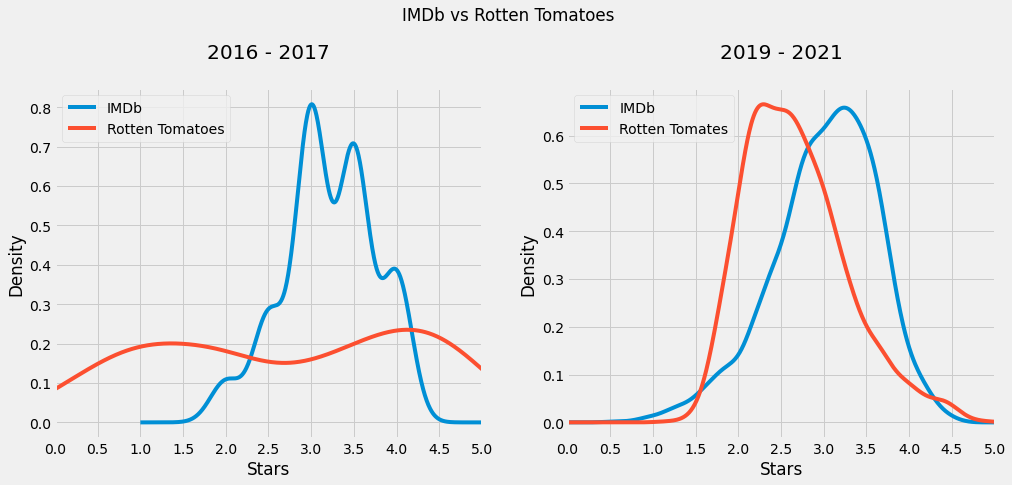

In [11]:
plt.subplot(1,2,1)
# 2016 - 2017 plot
after['IMDb'].plot.kde(label = 'IMDb', legend = True, figsize = (15,6))
after['Rotten Tomatoes'].plot.kde(label = 'Rotten Tomatoes', legend = True)

plt.title("2016 - 2017", y = 1.07)
plt.xlabel('Stars')
plt.xlim(0,5)
plt.xticks(arange(0,5.1,.5))

# 2019 - 2021
plt.subplot(1, 2, 2)
recent['IMDb'].plot.kde(label = 'IMDb', legend = True)
recent['Rotten Tomatoes'].plot.kde(label = 'Rotten Tomates', legend = True)

plt.title("2019 - 2021", y = 1.07)
plt.xlabel('Stars')
plt.xlim(0,5)
plt.xticks(arange(0,5.1,.5))
plt.suptitle('IMDb vs Rotten Tomatoes', y = 1.07)
plt.show()

Two aspects are striking on the figure above:
* Rotten Tomatoes used to have flat skewed distribution suggesting that it had an equal number of bad and good movies
* Starting from 2019, their distribution magically transformed to normal distribution suggesting movies on RT are given higher fan ratings compared to early years. Coupled with the fact that Fandango sells tickets, the higher ratings are a bit dubious.

***
## Conclusions
Continuing Walt's Hickey's analysis, our analysis shows there's still indeed a difference between Fandango's ratings for movies released in 2016 and 2017. We've also analyzed the change in the distribution of the ratings in Rotten Tomatoes after Fandango acquired them and revamp their audience rating system. Our study insists Fandango may be manipulating movie ratings to boost ticket sales.